In [5]:
import itertools

import cirq
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append("..")

from sim.circuit import gen_2d_grid_xeb_random_circuits
from sim.simulate import large_scale_xeb_sim
from sim.result import SampleResult

In [2]:
exponents = np.linspace(0, 7/4, 8)
SINGLE_QUBIT_GATES = tuple(
    cirq.PhasedXZGate(x_exponent=0.5, z_exponent=z, axis_phase_exponent=a)
    for a, z in itertools.product(exponents, repeat=2)
)

MAX_DEPTH = 400
cycle_depths = list(range(1, 21)) + [25, 35, 40]
e_pauli = 3e-3
e_dep = e_pauli / (1 - 1/2**2)
noise_model = cirq.devices.noise_model.ConstantQubitNoiseModel(cirq.depolarize(e_pauli))
n_circuits = 5
save_resume_filepath = "/home/cuquantum/xebsim/result/2d_grid/result.csv"

In [3]:
# grids = [(3, 3), (3, 4), (4, 4)]
grids = [(3, 3)]
res = {}
for grid in grids:
    qubits = cirq.GridQubit.rect(grid[0], grid[1])
    circuits, _ = gen_2d_grid_xeb_random_circuits(
        qubits=qubits,
        depth=MAX_DEPTH,
        num_circuits=n_circuits,
        two_qubit_op_factory=lambda a, b, _: cirq.SQRT_ISWAP(a, b)
    )
    cycle_xebs = [
        large_scale_xeb_sim(circuit, noise_model, cycle_depths=cycle_depths)
        for circuit in circuits
    ]
    res[grid[0] * grid[1]] = cycle_xebs

9 qubits noisy state simulation: 100%|██████████| 81/81 [00:16<00:00,  5.04it/s]


In [8]:
with open(save_resume_filepath, 'a') as f:
    for size, data in res.items():
        cycle_xebs = np.mean(data, axis=0)
        for cycle, xeb in zip(cycle_depths, cycle_xebs):
            result = SampleResult.from_dict({
                'task': "2d_grid_linear_xeb",
                'size': size,
                'circuit_id': '',
                'noise_model': repr(noise_model),
                'cycle_depth': cycle,
                'shots': None,
                'linear_xeb': xeb,
                'linear_xeb_std_err': None,
                'elapsed_time_sec': None,
                'time_per_shot_sec': None,
            })
            print(result.csv_line(), file=f, flush=True)
        

In [38]:

for grid in grids:
    n = grid[0] * grid[1]
    cycle_xebs = np.mean(res[n], axis=0)
    plt.plot(cycle_depths, cycle_xebs, label=f'{n} qubits')
plt.yscale('log')
plt.yticks(np.logspace(-2, 4, num=7))
plt.legend()
plt.title('2D grid')
plt.xlabel("Depth")
plt.ylabel("Linear XEB")
plt.show()


NameError: name 'grids' is not defined

In [6]:
import pandas as pd

df = pd.read_csv(save_resume_filepath)
df.columns = df.columns.str.strip()
xebs = df.groupby(['task', 'size', 'cycle_depth'])['linear_xeb'].mean()

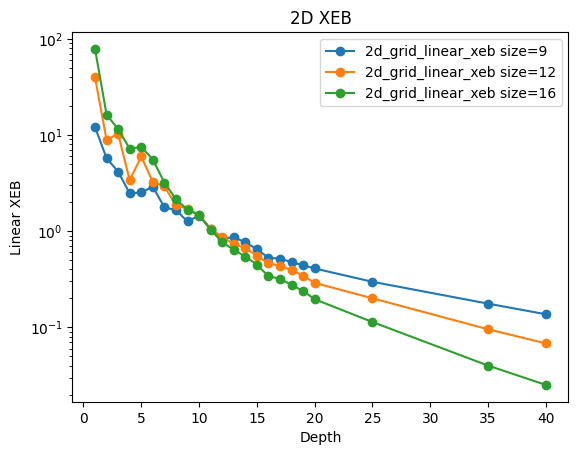

In [7]:
tasks = df['task'].unique()
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.set_yticks(np.logspace(-2, 4, num=7))
ax.set_title('2D XEB')
ax.set_xlabel("Depth")
ax.set_ylabel("Linear XEB")
for task in tasks:
    df_for_task = df[df['task'] == task]
    sizes = df_for_task['size'].unique()
    for size in sizes:
        df_for_size = df_for_task[df_for_task['size'] == size]
        depths = sorted(df_for_size['cycle_depth'].unique())
        linear_xebs = [xebs[(task, size, d)] for d in depths]
        ax.plot(depths, linear_xebs, label=f'{task} {size=}', marker='o')
ax.legend()